In [1]:
import os
import numpy as np
import pandas as pd
from time import sleep
from tqdm import tqdm
from PIL import Image
from pathlib import Path

import torch
from transformers import GLPNFeatureExtractor, GLPNForDepthEstimation
from transformers import MaskFormerImageProcessor, MaskFormerForInstanceSegmentation

In [2]:
processor_depth = GLPNFeatureExtractor.from_pretrained("vinvino02/glpn-nyu")
model_depth = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

processor_mask = MaskFormerImageProcessor.from_pretrained("facebook/maskformer-swin-small-coco")
model_mask = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-small-coco")

d:\miniconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\浩然\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
d:\miniconda3\lib\site-packages\transformers\models\glpn\feature_extraction_glpn.py:28: FutureWarning: The class GLPNFeatureExtractor is deprecated and will be rem

In [3]:
def get_depth(img):
    img = img.resize((512,512))
    inputs_d = processor_depth(img, return_tensors="pt").pixel_values

    import torch
    with torch.no_grad():
        outputs_d = model_depth(inputs_d)
        predicted_depth = outputs_d.predicted_depth
        predicted_depth.shape
    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
                        predicted_depth.unsqueeze(1),
                        size=inputs_d.shape[-2:],
                        mode="bicubic",
                        align_corners=False,
                )
    depth = prediction.squeeze().cpu().numpy()
    
    return depth

def get_mask(img):
    inputs_m = processor_mask(images=img, return_tensors="pt")
    outputs_m = model_mask(**inputs_m)
    predicted_semantic_map = processor_mask.post_process_semantic_segmentation(outputs_m, target_sizes=[img.size[::-1]])[0]

    return predicted_semantic_map

def get_nature_depth(img, label = None):
    #125:grass; 116:tree
    mask = get_mask(img)
    pre_depth = get_depth(img)
    
    mask = (np.array(mask) == label).astype(int) 
    pre_depth_mask = (pre_depth * mask).reshape(-1) [(pre_depth * mask).reshape(-1) != 0]
    
    return pre_depth_mask

In [11]:
input_dir = "D:/研究生/01Master/JNU/samples"
output_file = "D:/desk/depth_restoration/depth.csv"

all_data = []
for image_path in tqdm(Path(input_dir).glob("*.jpg")):
    image = Image.open(image_path)
    image = image.resize((512, 512))

    depth = get_nature_depth(image, label=116)  # 125:grass; 116:tree

    # Append data to list of all data
    data = {"filename": image_path.name}
    if depth.size > 0:
        data["depth_mean"] = depth.mean()
    else:
        data["depth_mean"] = None
    
    if depth.size > 0:
        data["depth_max"] = depth.max()
    else:
        data["depth_max"] = None
        
    if depth.size > 0:
        data["depth_min"] = depth.min()
    else:
        data["depth_min"] = None
    
    all_data.append(data)

# Save data to CSV file
df = pd.DataFrame.from_records(all_data, columns=["filename"] + ["depth_mean"] + ["depth_max"] + ["depth_min"])
df.set_index("filename", inplace=True)
df.to_csv(output_file)

0it [00:00, ?it/s]

200it [26:58,  8.09s/it]


In [7]:
# Save data to CSV file
df = pd.DataFrame.from_records(all_data, columns=["filename"] + ["total_pixels"])
df.set_index("filename", inplace=True)
df.to_csv(output_file)

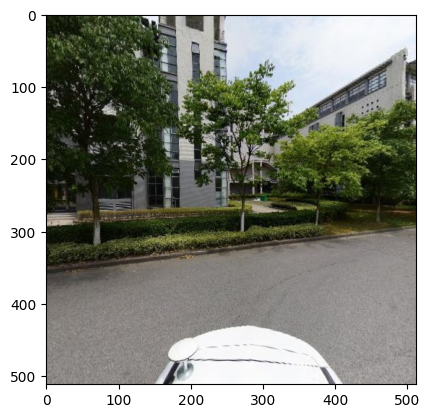

In [32]:
import matplotlib.pyplot as plt

X = Image.open("D:/desk/3.jpg")
plt.imshow(X)

In [33]:
data = get_nature_depth(X, label = 116)

In [34]:
data.min(), data.max()

(3.1030139923095703, 5.783949375152588)

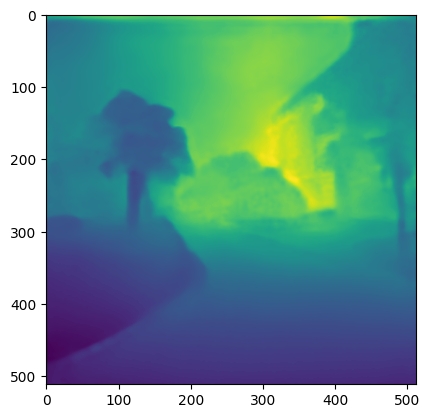

In [20]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
plt.imshow(get_depth(X))
# plt.savefig("D:/desk/JNU/imgdepth.jpg", dpi = 600)

In [1]:
import xgboost as xgb

In [3]:
xgb.__version__

'1.7.4'

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import joblib
from joblib import Parallel, delayed

In [252]:
# 从本地读取CSV文件并创建数据帧
data = pd.read_csv('D:/desk/depth_restoration/depth_wuhan_normalize.csv')
data.head(2)

X = data.iloc[:,4:] # 自变量x1和x2...
y = data.iloc[:,3] # 因变量y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [20]:
## 归一化

from sklearn.preprocessing import MinMaxScaler

col_to_normalize = data.columns[4:]
print(col_to_normalize)

scaler = MinMaxScaler()
data[col_to_normalize] = scaler.fit_transform(data[col_to_normalize])
data.to_csv("D:/desk/depth_restoration/depth_wuhan_normalize.csv", index = False)
print(data)

Index(['grass_depth_mean', 'grass_depth_max', 'grass_depth_min',
       'tree_depth_mean', 'tree_depth_max', 'tree_depth_min', 'building_seg',
       'tree_seg', 'road_seg', 'sky_seg', 'car_seg', 'plant_seg', 'van_seg',
       'sidewalk_seg', 'person_seg', 'bus_seg', 'fence_seg', 'grass_seg',
       'car_obj', 'person_obj', 'truck_obj', 'motorcycle_obj', 'bicycle_obj',
       'hue_mean', 'saturation_mean', 'light_mean', 'edge_mean'],
      dtype='object')
                             filename  average_score  labels_three  \
0     114.156143869_30.6128186974.png       0.851736             1   
1     114.158411111_30.6206021664.png       4.635862             2   
2       114.15942885_30.574736697.png       3.728554             2   
3     114.159630471_30.5788771409.png       4.782789             2   
4      114.15989869_30.6073719864.png       5.784184             3   
...                               ...            ...           ...   
998   114.452304836_30.4892352925.png       3.9470

In [253]:
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

classifiers = {
    "Nearest Neighbors": KNeighborsClassifier(5),
    "Linear SVM": SVC(kernel="linear", gamma=2,C=1, random_state=42),
    "RBF SVM": SVC(kernel="rbf", gamma=2, C=1, random_state=42),
    # "Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, 
                                            random_state=42),
    "Random Forest": RandomForestClassifier(max_depth=15, 
                                            n_estimators=5000, 
                                            random_state=42),
    "XGBoost": xgb.XGBClassifier(objective="binary:logistic",
                                learning_rate=0.01,
                                n_estimators=5000,
                                max_depth=15,
                                subsample=0.8,
                                colsample_bytree=0.8,
                                reg_alpha=0.1,
                                reg_lambda=0.1,
                                random_state=42),
    "Neural Net": MLPClassifier(alpha=1, 
                                learning_rate_init=0.001,
                                max_iter=5000, 
                                random_state=42)

    # "AdaBoost": AdaBoostClassifier(random_state=42),
    # "Naive Bayes": GaussianNB(),
    # "QDA": QuadraticDiscriminantAnalysis(),
}

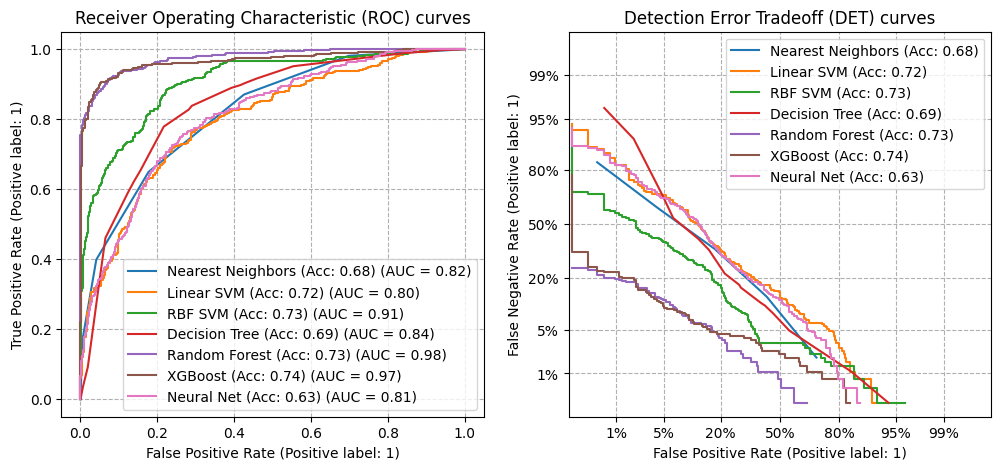

In [45]:
import matplotlib.pyplot as plt

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(12, 5))

for name, clf in classifiers.items():
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')  # 使用5倍交叉验证
    mean_score = np.mean(scores)

    clf.fit(X_train, y_train)

    RocCurveDisplay.from_estimator(clf, X, y, ax=ax_roc, name=f"{name} (Acc: {mean_score:.2f})")
    DetCurveDisplay.from_estimator(clf, X, y, ax=ax_det, name=f"{name} (Acc: {mean_score:.2f})")

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
# plt.savefig("D:/desk/depth_restoration/figure/roc_curve.svg")
plt.show()

In [254]:
# -*- coding: utf-8 -*-
from sklearn.metrics import accuracy_score, classification_report

xgb_cls = xgb.XGBClassifier(objective="binary:logistic", # 分类目标函数
                            learning_rate=0.01,
                            n_estimators=5000,
                            max_depth=15,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            reg_alpha=0.1,
                            reg_lambda=0.1,
                            random_state=50)

# 使用5折交叉验证
# cv_scores = cross_val_score(xgb_cls, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# 打印准确率得分
# print("Cross-validation scores: ", cv_scores)
# print("Mean score: ", cv_scores.mean())

xgb_cls.fit(X_train, y_train)

y_pred = xgb_cls.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# 打印分类报告
classification_rep = classification_report(y_test, y_pred)
print('Classification Report:')
print(classification_rep)

Accuracy: 0.7674418604651163
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       182
           1       0.75      0.61      0.68       119

    accuracy                           0.77       301
   macro avg       0.76      0.74      0.75       301
weighted avg       0.77      0.77      0.76       301



In [48]:
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[156,  26],
       [ 46,  73]], dtype=int64)

In [47]:
import shap
shap.initjs()  # notebook环境下，加载用于可视化的JS代码

In [255]:
explainer = shap.TreeExplainer(xgb_cls)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
shap_values

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


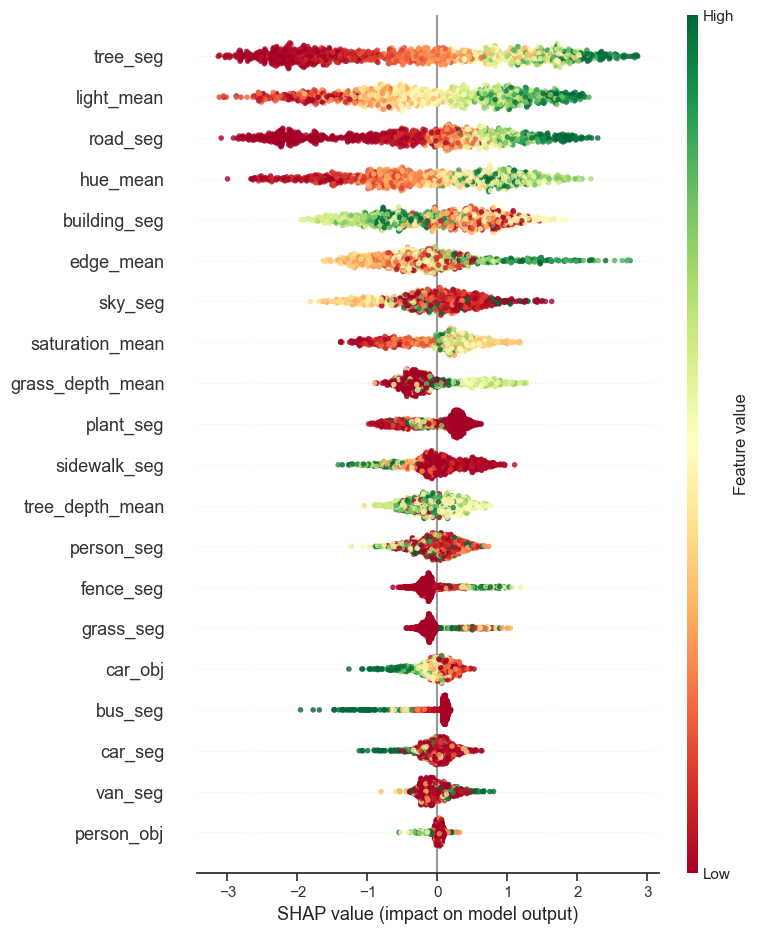

In [276]:
shap.summary_plot(shap_values, X, max_display=20, alpha=0.8, cmap="RdYlGn", show=False)
# plt.savefig("D:/desk/depth_restoration/figure/shap.svg")

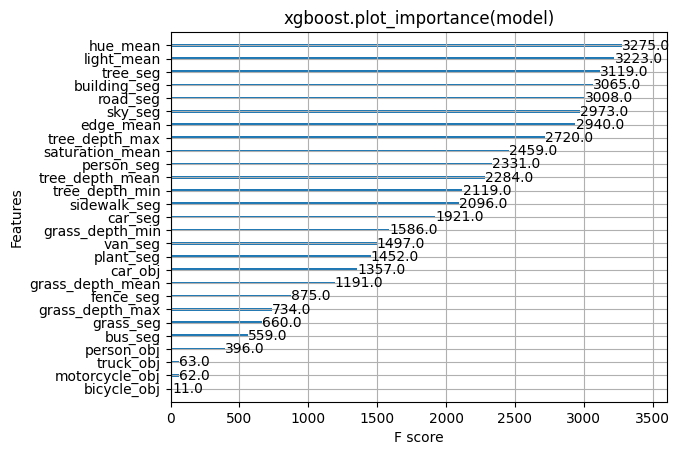

In [83]:
xgb.plot_importance(xgb_cls)
plt.title("xgboost.plot_importance(model)")
plt.show()

In [145]:
shap.plots.scatter??

Signature:
shap.plots.scatter(
    shap_values,
    color='#1E88E5',
    hist=True,
    axis_color='#333333',
    cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x000002028E1908E0>,
    dot_size=16,
    x_jitter='auto',
    alpha=1,
    title=None,
    xmin=None,
    xmax=None,
    ymin=None,
    ymax=None,
    overlay=None,
    ax=None,
    ylabel='SHAP value',
    show=True,
)
Source:   
def scatter(shap_values, color="#1E88E5", hist=True, axis_color="#333333", cmap=colors.red_blue,
            dot_size=16, x_jitter="auto", alpha=1, title=None, xmin=None, xmax=None, ymin=None, ymax=None,
            overlay=None, ax=None, ylabel="SHAP value", show=True):
    """ Create a SHAP dependence scatter plot, colored by an interaction feature.

    Plots the value of the feature on the x-axis and the SHAP value of the same feature
    on the y-axis. This shows how the model depends on the given feature, and is like a
    richer extenstion of classical parital dependence plots. Vert

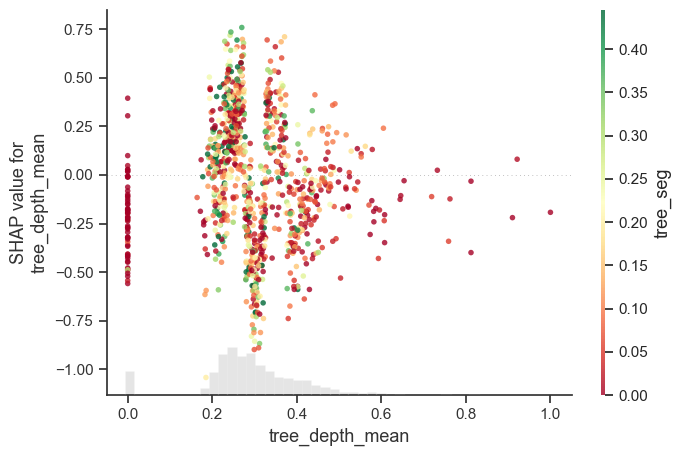

In [277]:
import matplotlib.pyplot as plt
shap.plots.scatter(shap_values[:, 1], color=shap_values[:, 3], cmap="RdYlGn", alpha=0.8, show=False)
# plt.savefig("D:/desk/depth_restoration/figure/tree_shap.svg")

In [142]:
shap_values[:, 0]

.values =
array([-0.20567846, -0.2032096 ,  0.5396826 , ..., -0.18486111,
       -0.15992723, -0.21604717], dtype=float32)

.base_values =
array([-0.6117851, -0.6117851, -0.6117851, ..., -0.6117851, -0.6117851,
       -0.6117851], dtype=float32)

.data =
array([0.        , 0.        , 0.31836224, ..., 0.        , 0.        ,
       0.        ])

In [147]:
X

,grass_depth_mean,grass_depth_max,grass_depth_min,tree_depth_mean,tree_depth_max,tree_depth_min,building_seg,tree_seg,road_seg,sky_seg,...,grass_seg,car_obj,person_obj,truck_obj,motorcycle_obj,bicycle_obj,hue_mean,saturation_mean,light_mean,edge_mean
0,0.000000,0.000000,0.000000,0.173729,0.138277,0.164334,0.9490,0.006027,0.000000,0.087942,...,0.000000,0.117647,0.0,0.0,0.0,0.0,0.158622,0.282776,0.509291,0.342550
1,0.000000,0.000000,0.000000,0.238969,0.388376,0.184943,0.5132,0.282342,0.225672,0.180770,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.479558,0.195039,0.644679,0.296148
2,0.318362,0.231459,0.299459,0.334408,0.378738,0.212646,0.4076,0.057553,0.548888,0.000782,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.699640,0.159859,0.476380,0.398390
3,0.000000,0.000000,0.000000,0.492871,0.446170,0.291371,0.0114,0.044898,0.946247,0.829197,...,0.000000,0.117647,0.0,0.0,0.0,0.0,0.564542,0.067729,0.673040,0.195273
4,0.000000,0.000000,0.000000,0.258473,0.289322,0.174718,0.0552,0.378767,0.190222,0.730702,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.438330,0.224213,0.786590,0.475640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,0.323828,0.339115,0.276616,0.241157,0.295198,0.160439,0.3773,0.220972,0.462929,0.025796,...,0.080264,0.117647,0.0,0.0,0.0,0.0,0.307105,0.129790,0.710562,0.246596
999,0.000000,0.000000,0.000000,0.225148,0.232688,0.183073,0.2840,0.085777,0.401993,0.696502,...,0.000000,0.235294,0.0,0.0,0.0,0.0,0.686736,0.068183,0.658650,0.167346
1000,0.000000,0.000000,0.000000,0.227676,0.197581,0.199825,0.0518,0.028224,0.702502,0.668947,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.588536,0.161267,0.745995,0.283525
1001,0.000000,0.000000,0.000000,0.366205,0.547377,0.269960,0.0894,0.014966,0.340593,0.866328,...,0.000000,0.235294,0.0,0.0,0.0,0.0,0.676159,0.062683,0.864528,0.195190


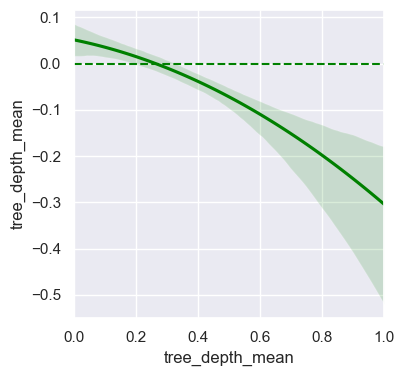

In [247]:
import seaborn as sns
import shap

plt.figure(figsize=(4, 4))

sns.set_style('darkgrid')
# 创建SHAP值的DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
merged_data = pd.concat([shap_df['tree_depth_mean'], X['tree_depth_mean']], axis=1)
# 绘制散点图
# sns.scatterplot(data=merged_data, x = merged_data.iloc[:,1], y = merged_data.iloc[:,0], size=0.1)
sns.regplot(
    data=merged_data, x = merged_data.iloc[:,1], y = merged_data.iloc[:,0],
    scatter=False, truncate=False, order=2, color="green")

plt.axhline(y=0, color='green', linestyle='--')

plt.show()

In [178]:
sns.regplot??

Signature:
sns.regplot(
    data=None,
    *,
    x=None,
    y=None,
    x_estimator=None,
    x_bins=None,
    x_ci='ci',
    scatter=True,
    fit_reg=True,
    ci=95,
    n_boot=1000,
    units=None,
    seed=None,
    order=1,
    logistic=False,
    lowess=False,
    robust=False,
    logx=False,
    x_partial=None,
    y_partial=None,
    truncate=True,
    dropna=True,
    x_jitter=None,
    y_jitter=None,
    label=None,
    color=None,
    marker='o',
    scatter_kws=None,
    line_kws=None,
    ax=None,
)
Docstring:
Plot data and a linear regression model fit.

There are a number of mutually exclusive options for estimating the
regression model. See the :ref:`tutorial <regression_tutorial>` for more
information.    

Parameters
----------
x, y: string, series, or vector array
    Input variables. If strings, these should correspond with column names
    in ``data``. When pandas objects are used, axes will be labeled with
    the series name.
data : DataFrame
    Tidy ("long-

<AxesSubplot: xlabel='cylinders', ylabel='acceleration'>

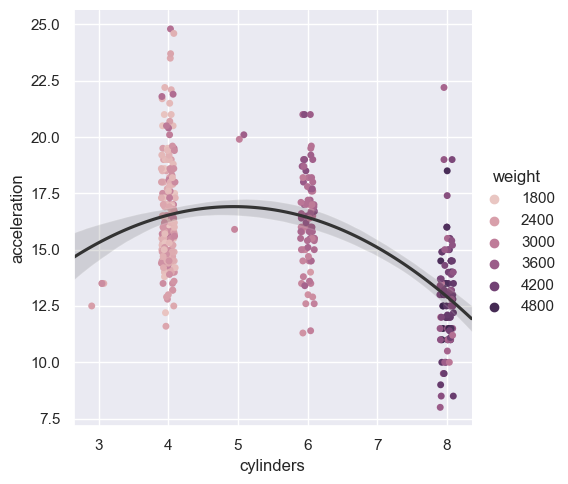

In [151]:
import seaborn as sns
sns.set_theme()

mpg = sns.load_dataset("mpg")
sns.catplot(
    data=mpg, x="cylinders", y="acceleration", hue="weight",
    native_scale=True, zorder=1
)
sns.regplot(
    data=mpg, x="cylinders", y="acceleration",
    scatter=False, truncate=False, order=2, color=".2",
)

In [98]:
shap.dependence_plot(4, shap_values[:,1], X, cmap="PiYG")

TypeError: order must be str, not int

In [32]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

shap_pca50 = PCA(n_components=6).fit_transform(shap_values[:1000, :])
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[:1000, :])

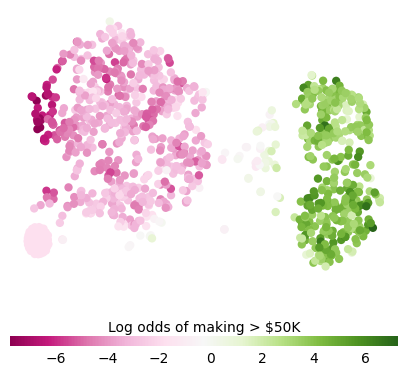

In [44]:
import matplotlib.pylab as pl

f = pl.figure(figsize=(5, 5))
pl.scatter(
    shap_embedded[:, 0],
    shap_embedded[:, 1],
    c=shap_values[:1000, :].sum(1).astype(np.float64),
    linewidth=0,
    alpha=1.0,
    cmap='PiYG',
)

cb = pl.colorbar(label="Log odds of making > $50K", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.outline.set_linewidth(0)
cb.ax.tick_params("x", length=0)
cb.ax.xaxis.set_label_position("top")
pl.gca().axis("off")
pl.show()